# 1. Setup

In [53]:
!pip install tensorflow
!pip install torch
!pip install transformers
!pip install seaborn

In [54]:
# imports
import torch
import tensorflow as tf
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig

In [55]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print(f'Found GPU at: {device_name}')
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [56]:
torch.cuda.empty_cache()

In [57]:
if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('GPU to be used:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU to be used: Tesla T4


In [58]:
!nvidia-smi

Mon May  9 00:29:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |   4340MiB / 15109MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [59]:
# Helper function to save our model:

import os
output_dir = 'model/bert'

def save_model(output_dir):

  # Create output directory if needed
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)
  print("Saving model to %s" % output_dir)
  # Save a trained model, configuration and tokenizer using `save_pretrained()`.
  # They can then be reloaded using `from_pretrained()`
  model_to_save = model.modules if hasattr(model, 'module') else model  # Take care of distributed/parallel training
  model_to_save.save_pretrained(output_dir, save_config=True)
  tokenizer.save_pretrained(output_dir)
  print("model saved")

## 2. Load data

labels_tensor.bin and tokens_tensor.bin were generated 

In [60]:
labels_tensor = torch.load('labels_tensor.bin')
tokens_tensor = torch.load('tokens_tensor.bin')
print("Loaded tensor data \n" 
      f"Total datapoints: {len(labels_tensor)}")

Loaded tensor data 
Total datapoints: 3940


## 3. Load BERT for sequence classification

In [61]:
NUM_LABELS = 1000
BATCH_SIZE = 32

In [62]:
print('Loading BERT model and tokenizer...')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                           num_labels = NUM_LABELS, 
                                                           output_attentions = True, 
                                                           output_hidden_states = True
                                                           )
model.cuda()
print("Loaded")

Loading BERT model and tokenizer...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Loaded


## 4. Training & Validation Split


In [63]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset:
dataset = TensorDataset(tokens_tensor, labels_tensor)

# Create a 95-5 train-validation split:

train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,743 training samples
  197 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [64]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

# 4. Model training

## 4.1. Optimizer & Learning Rate Scheduler

In [65]:
from transformers import get_linear_schedule_with_warmup

epochs = 30 
batch_size = BATCH_SIZE

total_steps = len(train_dataloader) * epochs

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Learning rate scheduler:
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [66]:
# Helper function to format elapsed times 
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [67]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## 4.2. Training Loop

In [68]:
import random
import numpy as np

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        if step % 5000 == 0 and not step == 0:
            
            save_model(output_dir + str(step) + '/')


        # Unpack this training batch from our dataloader. 

        b_input_ids = batch[0].to(device)
        # b_input_mask = batch[1].to(device)
        b_labels = batch[1].to(device)


        model.zero_grad()        

        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                            #  attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        # b_input_mask = batch[1].to(device) # note masking not used
        b_labels = batch[1].to(device)
        
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                  #  attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    if epoch_i % 5 == 0:
      save_model(output_dir + '_epoch_' + str(epoch_i+1))


save_model(output_dir + 'final')


print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 30 ========
Training...
  Batch    40  of    117.    Elapsed: 0:00:08.
  Batch    80  of    117.    Elapsed: 0:00:16.

  Average training loss: 6.85
  Training epcoh took: 0:00:24

Running Validation...
  Accuracy: 0.00
  Validation Loss: 6.70
  Validation took: 0:00:00
Saving model to model/bert_epoch_1
model saved

======== Epoch 2 / 30 ========
Training...
  Batch    40  of    117.    Elapsed: 0:00:08.
  Batch    80  of    117.    Elapsed: 0:00:16.

  Average training loss: 6.58
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.00
  Validation Loss: 6.52
  Validation took: 0:00:00

======== Epoch 3 / 30 ========
Training...
  Batch    40  of    117.    Elapsed: 0:00:08.
  Batch    80  of    117.    Elapsed: 0:00:16.

  Average training loss: 6.44
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.00
  Validation Loss: 6.46
  Validation took: 0:00:00

======== Epoch 4 / 30 ========
Training...
  Batch    40  of    117.    Elapsed

# 5. Training Process - Summary

In [74]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,6.85,6.70,4.46e-03,0:00:24,0:00:00
2,6.58,6.52,4.46e-03,0:00:23,0:00:00
3,6.44,6.46,4.46e-03,0:00:23,0:00:00
4,6.37,6.42,4.46e-03,0:00:23,0:00:00
5,6.26,6.23,1.34e-02,0:00:23,0:00:00
6,6.02,5.97,4.46e-02,0:00:23,0:00:00
7,5.74,5.66,1.91e-01,0:00:23,0:00:00
8,5.46,5.39,2.87e-01,0:00:23,0:00:00
9,5.19,5.16,3.71e-01,0:00:23,0:00:00


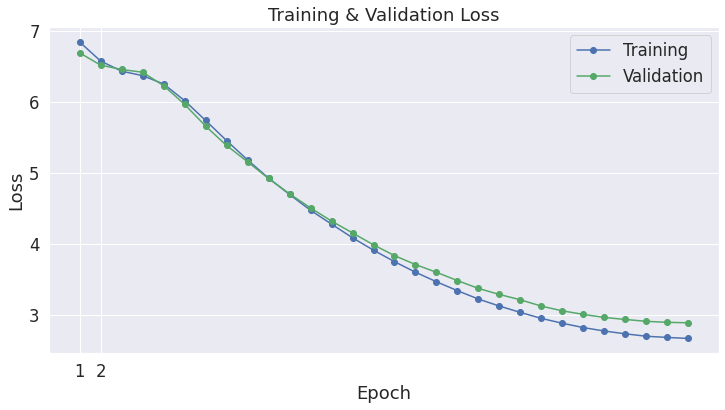

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2]) #, 3, 4])

plt.show()

# 6. Test Set Performance

## 6.2. Evaluate on Test Set


In [71]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in train_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  # b_input_ids, b_input_mask, b_labels = batch
  b_input_ids, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      # outputs = model(b_input_ids, token_type_ids=None, 
      #                 attention_mask=b_input_mask)
      outputs = model(b_input_ids, token_type_ids=None)

  logits = outputs[0]
  

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('Done with test set evaluation.')

Done with test set evaluation.


## Test set accuracy

In [72]:
predictions_flat = []
true_flat = []
for pred_b, true_b in zip(predictions, true_labels):

  for pred in pred_b:
    pred = list(pred)
    max_value = max(pred)
    max_index = pred.index(max_value)

    predictions_flat.append(max_index)

  true_flat += list(true_b)

In [73]:
true = 0
false = 0
for tru, pred in zip(true_flat, predictions_flat):
    if tru == pred:
      true += 1
    else:
      false += 1 

print(f"Accuracy across all classes: {'{:.3f}'.format(true / (false + true))}" )

Accuracy across all classes: 0.961
